# Confidence bands and envelopes

Confidence intervals is a good way to visualise uncertainty of a particular paramater.
However, we are sometimes interested in the uncertainty many parameters or in the uncertainty of a function:

* how a predictor $f:[0,1]\to\mathbb{R}$ depends on the training set
* how a ROC curve $\mathrm{Roc}:[0,1]\to[0,1]$ depends on the test set
* where a quantile-quantile plot $\mathrm{qq}:[0,1]\to[0,1]$ should lie if the null hypotesis is satisfied

To adress this issue, we can compute confidence intervals for individual inputs and then draw the corresponding envelope. Such an envelope is called a **pointwise confidence band**. 
Alternatively, we might be able to find an envelope where the function is expected to be in $95\%$ fraction of cases. 
Such an envelope is called **simultaneous confidence band**.
For obvious reasons, simultaneous confidence bands are much wider than pointwise bands.  

Confidence envelopes can be devised also for visualising uncertainty of several parameters at once. For instance, showing the uncertainty of mean and variance estimtors at the same figure. 

In the following, we explain how to compute pointwise confidece intervals for the examples listed above.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import numpy.random as rnd

from pandas import Series
from pandas import DataFrame

from tqdm import tnrange
from plotnine import *

# Local imports
from common import *
from convenience import *

## I. What is a quantile-quantile plot?

We can compare data sources by comparing samples taken form them. 
For instance, we can compute the mean value and variance for both samples and compare them.
This gives a nice overview but discards a lot of information about the exact shapes of the distributions.

Quantile-quantile plots are the best way to compare samples from two different distributions. In brief, if `x` and `y` are sample vectors of same size coming from two different distributions then
then plotting `x.sort()` against `y.sort()` produces qq-plot.

By sorting the values, we compute the quantiles of the distribution. Hence, the plot visualises how the corresponding quantiles are related. If `x` and `y` come from the same distribution, the resulting graph should ideally follow the line $x = y$. Due to random fluctuations, the plot deviates from a straight line. 
In the following, we take the frequentistic viewpoint and ask how big deviations occur on average if $x$ and $y$.

### Quantile-quantile plot for samples from  uniform distribution 

In [2]:
df = [None] * 3

n = 10
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[0]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

n = 100
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[1]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

n = 1000
x = rnd.uniform(size=n)
y = rnd.uniform(size=n)
df[2]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(label = 'n={}'.format(n))

mdisplay([head(df[0]), head(df[1]), head(df[2])], ['n=10', 'n=100', 'n=1000'])
df = pd.concat(df, ignore_index=True)

n=10,n=100,n=1000
x,y,label
0.080679,0.008265,n=10
0.247847,0.124337,n=10
0.319399,0.182657,n=10
0.328979,0.183415,n=10
0.388135,0.543181,n=10
x,y,label
0.023541,0.018111,n=100
0.029299,0.022156,n=100
0.054471,0.027533,n=100


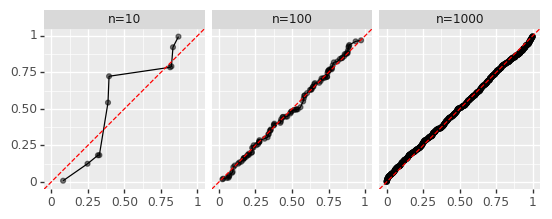

<ggplot: (7551945757)>

In [3]:
p = ggplot(df)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha=0.5)
p = p + geom_line(aes(x = 'x', y = 'y'))
p = p + facet_wrap(['label'])
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name='') + scale_y_continuous(name='')
p = p + geom_abline(intercept = 0, slope = 1, color = 'red', linetype ='--')
display(p)

## II. Distribution of quantile-quantile plots

If the null hypotesis holds and all both samples are taken form the same distribution we get a distribution over functions of type $\mathrm{qq}:[0,1]\to[0,1]$. 
The simplest way to characterise the distribution is through simulation.
That is, we draw many sample pairs $x$ and $y$ from the same distribution and observe how does qq-plot look like on average. As the fluctuations depend on the data distribution, we must fix a distribution before visualising the distribution of qq-lines.

###  Sampling procedure for the uniform distribution

In [4]:
sim = [None] * 100
for i in range(len(sim)):
    n = 10
    x = rnd.uniform(size=n)
    y = rnd.uniform(size=n)
    sim[i]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(run = i)

sim = pd.concat(sim, ignore_index=True)    

### Naive visualisation of the corresponding distribution of qq-lines

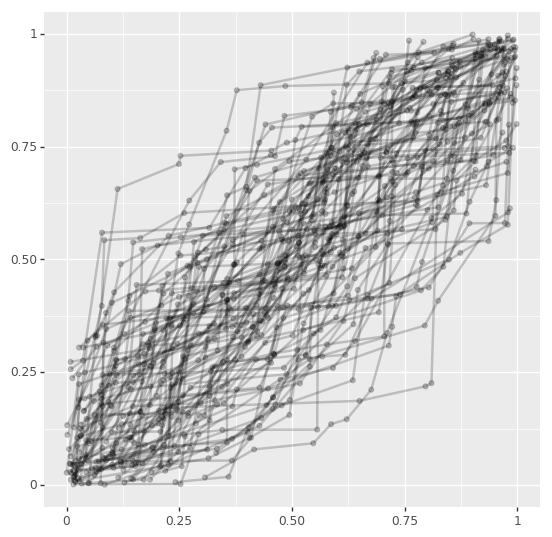

<ggplot: (-9223372029302805644)>

In [5]:
p = ggplot(sim)
p = p + geom_point(aes(x = 'x', y = 'y'), alpha = 0.2 )
p = p + geom_line(aes(x = 'x', y = 'y', group ='run'), alpha = 0.2, size = 1)
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
display(p)
p.save('qq_line_distribution.pdf', path='results', height=6, width=6, verbose=False)

## III. Simulation based confidence envelope for quantile-quantile plot

The visualisation shown above is not very revaling, as there are too much information to consider.
We can reduce the amount of infomration by considering the behavior of qq-lines $\mathrm{qq}(\cdot)$ at a fixed set of gridpoints $\xi_j$.
In particular, we can compute quantiles for the values $\mathrm{qq}(\xi_j)$. 
As the qq-line is piece-wise linear function fixed by the observation pairs $(x_i, y_i)$, we need a linear interpolation routine 
[`scipy.interpolate.interp1d`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp1d.html#scipy.interpolate.interp1d)
from `scipy` for eveluating $\mathrm{qq}(\xi_j)$

### More thorough data gathering

We need more simulations to get precise enough quantile estimates - 100 samples are no enough to adequately fix $2.5\%$ and $97.5\%$ quantiles.

In [6]:
sim = [None] * 1000
for i in tnrange(len(sim)):
    n = 10
    x = rnd.uniform(size=n)
    y = rnd.uniform(size=n)
    sim[i]= DataFrame({'x': np.sort(x), 'y': np.sort(y)}).assign(run = i)

sim = pd.concat(sim, ignore_index=True)  

### Example case for fixing interpolating routine

Lets start form an example and extend it later on to define a function for tabulating $\mathrm{qq}(\xi_j)$ values.

In [7]:
from scipy.interpolate import interp1d

In [8]:
# Fix the interpolation grid
xi = np.arange(0, 1.001, 0.05)

# Extract a single run for the experiment   
df = sim.loc[sim['run']==0, ['x', 'y']]

# Fix endpoints for complete interpolation
if df.iloc[0, 0] != 0:
    df = df.append(df.iloc[0]).shift(1)
    df.iloc[0,:] = 0
    
if df.iloc[-1,0] != 1:
    df = df.append(Series({'x': 1, 'y': 1}), ignore_index=True)
    
# Define interpolator and evalute it on the grid
interp1d(df['x'], df['y'])(xi)

array([0.        , 0.4244501 , 0.57575774, 0.61337221, 0.6205672 ,
       0.63361956, 0.64667192, 0.65863309, 0.66776794, 0.70875357,
       0.75181253, 0.79099144, 0.82590302, 0.86081461, 0.89572619,
       0.92849289, 0.95969431, 0.98287392, 0.98858262, 0.99429131,
       1.        ])

### Function for tabulating $\mathrm{qq}(\xi_i)$ values on the grid

In [9]:
def tabulate_qq(run: DataFrame, xi: np.array) -> DataFrame:
    """Uses linear interpolation to tabulate values of qq-line on a grid"""
    
    df = run[['x', 'y']].copy()
    
    # Fix endpoints for complete interpolation
    if df.iloc[0, 0] != 0:
        df = df.append(df.iloc[0]).shift(1)
        df.iloc[0,:] = 0

    if df.iloc[-1,0] != 1:
        df = df.append(Series({'x': 1, 'y': 1}), ignore_index=True)
    
    # Define interpolator and evalute it on the grid
    return DataFrame({'x': xi, 'y': interp1d(df['x'], df['y'])(xi)})    

Visual verification

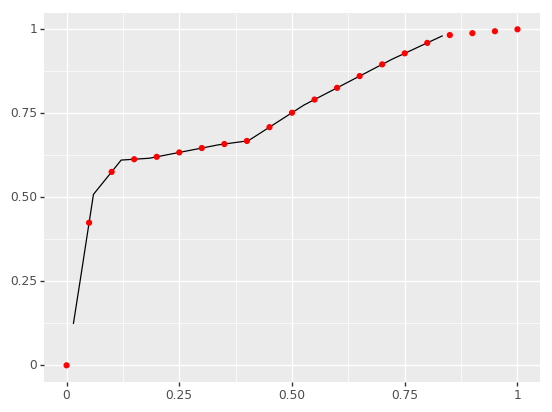

<ggplot: (-9223372029302156414)>

In [10]:
run = sim.loc[sim['run']==0]
p = ggplot(tabulate_qq(run, xi = np.arange(0, 1.001, 0.05)))
p = p + geom_line(aes(x = 'x', y = 'y'), data = run)
p = p + geom_point(aes(x = 'x', y = 'y'), color = 'red')
p + scale_x_continuous(name = '') + scale_y_continuous(name = '')

### Tabulation of $\mathrm{qq}(\xi_i)$ values for the entire simulation

In [11]:
df = (sim.groupby('run').apply(tabulate_qq, xi)
      .reset_index('run')
      .reset_index(drop=True))
display(head(df))

,run,x,y
0,0,0.00,0.000000
1,0,0.05,0.424450
2,0,0.10,0.575758
3,0,0.15,0.613372
4,0,0.20,0.620567


### Quantile computation on tabulated values

In [12]:
result = (df[['x', 'y']].groupby('x')
          .aggregate('quantile', [0.025, 0.5, 0.975])
          .unstack()
          .pipe(reset_column_index, 0)
          .rename(columns = {0.025: 'q_025', 0.5: 'q_500', 0.975: 'q_975'})
          .reset_index())

head(result)

,x,q_025,q_500,q_975
0,0.00,0.000000,0.000000,0.000000
1,0.05,0.001770,0.046688,0.339090
2,0.10,0.003747,0.096664,0.485380
3,0.15,0.008315,0.148143,0.542274
4,0.20,0.014993,0.201111,0.599303


### Final visualisation of resulting pointwise 90% confidence band

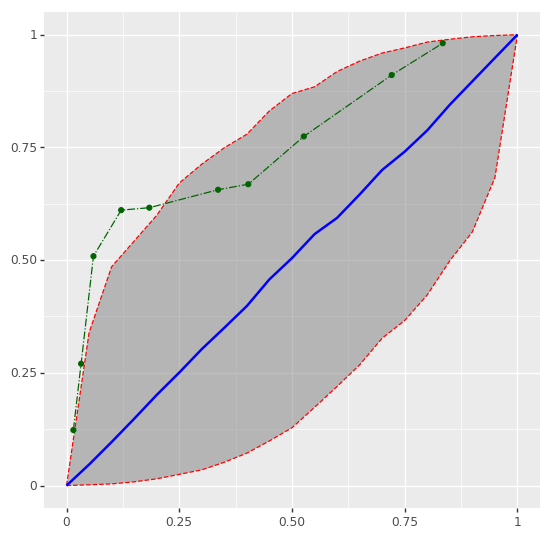

<ggplot: (-9223372029302762850)>

In [13]:
run = sim.loc[sim['run']==0]

p = ggplot(result)
p = p + geom_ribbon(aes(x = 'x', ymin = 'q_025', ymax = 'q_975'), 
                        fill = 'gray', alpha = 0.5, color = 'red', linetype = '--')
p = p + geom_line(aes(x = 'x', y = 'q_500'), color = 'blue', size = 1)
p = p + geom_point(aes(x = 'x', y ='y'), data = run, color = 'darkgreen')
p = p + geom_line(aes(x = 'x', y ='y'), data = run, color = 'darkgreen', linetype='-.')
p = p + coord_fixed(ratio = 1, xlim = [0,1])
p = p + scale_x_continuous(name = '') + scale_y_continuous(name = '')
display(p)
p.save('qq_confidence_envelope.pdf', path='results', height=6, width=6, verbose=False)

# Homework

## 3. 1 Distribution of qq-lines depends on the source  and sample size (<font color='red'>1p</font>)

So far we computed the confidence envelope for a very specific case. As the fluctuations might depend on the data distribution and sample size, experiment with different distributions. Use uniform, normal and exponential distributions from `numpy.random` and take $100$ and $1000$ samples for $x$ and $y$.
For each setup, repeat this experiment 100 times and draw points defining qq-line on the same graph.
Use experiment with different `alpha` values to get the best representation. As a result, you should get three different fluctuation patterns. Interpret results.

In [17]:
rnd.uniform(size=10)
rnd.normal(size=20)
rnd.exponential(size=20)

array([0.65868569, 0.69417408, 0.19267753, 0.76123612, 0.77211475,
       0.4441018 , 0.51935537, 0.13072223, 1.10638441, 0.62641681,
       0.07860495, 0.33310502, 0.67249709, 1.70571081, 2.32281062,
       1.45706639, 1.11602961, 1.04556832, 0.24791111, 1.38468804])

## 3.2 Confidence envelopes through simulations (<font color='red'>1p</font>)

If the distribution to compare with is known, then the use of theoretical quantiles reduces the amount of noise in the graph. For instance, if we want to compare a sample vector $y$ of size $100$ with uniform distribution, we can set 
~~~~
x = scipy.stats.uniform().ppf(np.arrange(0, 1.0001, 0.01))
~~~~
to set theoretical quantiles on the $x$-axis. This gives a sightly simpler way to compute confidence envelope:

*  Draw $1000$ sample vectors $y$ of size 100 for all distributions.
*  Compute desired empirical quantiles with `numpy.quantile` or `sort` 
~~~~~
q = np.arange(0, 1.001, 0.01)
Q.iloc[i,:] = np.quantile(y, q = q)
~~~~~
   and store results into a row of a $1000\times 100$ matrix `Q`. 
 
* As a result, every column `Q.iloc[:,j]` represents individual measurements of a quantile `q[j]` and you can compute compute 2.5%, 50% and 97.5% empirical quantiles for each `q[j]`. 
  With these you values you can draw the confidence envelope. 
  Draw these confidence envelopes on a separate plot for all three distributions.

Alternatively, you can construct the confidence envelope similarly to the way we constructed the the envelope above with the exeption that there is no need to use interpolation -- all $\mathrm{qq}(\xi_j)$ values will correspond to some $y_i$. 


In [29]:
stats.uniform.ppf(np.arange(0, 1.001, 0.01))
stats.norm.ppf(np.arange(0, 1.001, 0.01))
stats.expon.ppf(np.arange(0, 1.001, 0.01))
pass

## 3.3 Theoretical confidence envelopes for uniform distribution (<font color='red'>1p</font>)

In general, finding analytical confidence intervals for the qq-plot is intractable unless you compare a sample against known distribution with simple enough cumulative distribution function.
In particular, there is a closed form solution for uniform distribution over $[0,1]$.
Let $\boldsymbol{y}$ be an $n$ elelment i.i.d. sample from uniform distribution, i.e., all components are independent and uniformly distributed.
Then $\boldsymbol{z}\gets \mathrm{sort}(\boldsymbol{y})$ then $z_k$ is distributed according to beta distribution with parameters $k$ and $n+1-k$. Hence, for uniform distribution we can provide analytical confidence intervals by solving the equations:

\begin{align*}
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \alpha]= 2.5\% \\
     & \Pr[z_k\gets\mathcal{B}(k, n+1-k): z_k\leq \beta]= 97.5\%\enspace.
\end{align*}

for $\alpha$ and $\beta$. For that you can use function `scipy.stats.beta.ppf` with appropriate parameters. Draw the corresponding graph and compare with empirical results you obtained in the previous exercise. 
How many points of qq-plot should lie outside confidence intervals if $\boldsymbol{y}$ is  uniform distribution?
Veryfy your quess with few samples drawn on top of the confidence envelope.


In [31]:
stats.beta(1,3).ppf(np.arange(0, 1.001, 0.01))

array([0.        , 0.00334451, 0.00671161, 0.0101017 , 0.01351517,
       0.01695243, 0.02041389, 0.02389999, 0.02741117, 0.03094789,
       0.03451062, 0.03809983, 0.04171603, 0.04535973, 0.04903146,
       0.05273176, 0.0564612 , 0.06022036, 0.06400984, 0.06783025,
       0.07168223, 0.07556645, 0.07948359, 0.08343435, 0.08741947,
       0.0914397 , 0.09549583, 0.09958867, 0.10371905, 0.10788786,
       0.112096  , 0.11634441, 0.12063407, 0.12496599, 0.12934123,
       0.13376089, 0.13822612, 0.14273811, 0.1472981 , 0.15190739,
       0.15656733, 0.16127935, 0.16604491, 0.17086557, 0.17574294,
       0.18067873, 0.18567472, 0.19073277, 0.19585485, 0.20104303,
       0.20629947, 0.21162648, 0.21702647, 0.22250199, 0.22805574,
       0.23369057, 0.23940951, 0.24521577, 0.25111276, 0.25710412,
       0.2631937 , 0.26938564, 0.27568436, 0.28209456, 0.28862134,
       0.29527013, 0.3020468 , 0.30895768, 0.31600962, 0.32321005,
       0.33056705, 0.33808941, 0.34578674, 0.35366959, 0.36174

## 3.4  Confidence envelopes for unknown distribution using bootstrapping* (<font color='red'>3p</font>)

The methods scketched above work if at leat one distribution is known. The latter is not the case for most cases in practise. One way to solve this issue is to use bootstrap samples form $\boldsymbol{x}$. This allows us to replicate computations done in the first part of the notebook. 

Note that we can do slightly better by using continious bootstrapping that adds Gaussian noise to the bootstrap samples.
The original bootstaping corresponds to sampling form the distribution that is defined by the raw histogram of $\boldsymbol{x}$. 
This might be quite rough descriotion of the distribution and introduce unwanted artefacts.
It is quite common to smooth the histogram using Gaussian kernel to mitigate this issue. 

By adding a Gaussian noise with the right standard deviation $\sigma$ does the kernel smooting wihtout explicitly computing the smoothed histogram.
[A rule-of-thumb bandwidth estimator](https://en.wikipedia.org/wiki/Kernel_density_estimation#A_rule-of-thumb_bandwidth_estimator) 
$\sigma = 1.06\hat{\sigma}n^{-1/5}$ would be sufficient for our purposes.

Based on these knowledge design an algorithm for computing confidence envelopes for two samples $\boldsymbol{x}$ and $\boldsymbol{y}$ without no knowledge about the data source:

* Implement continuous bootstrap and draw the many samples to verify that the resulting histogram is smoothed as expected.
* Compute simulation based confidence envelope with continous bootstrap.
* Compute simulation based confidence envelope with standard bootstrap.
* Compare confidence envelopes and interpret results.

You may use samples from any distribution but it would make sense to condider uniform, normal or exponential distribution as we know how to generate precise confidence envelopes.

In [ ]:
%config IPCompleter.greedy=True